# Image Generation
In this notebook we will continue our exploration of image gradients using the deep model that was pretrained on TinyImageNet. We will explore various ways of using these image gradients to generate images. We will implement class visualizations, feature inversion, and DeepDream.

In [1]:
# As usual, a bit of setup

import time, os, json
import numpy as np
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt

from cs231n.classifiers.pretrained_cnn import PretrainedCNN
from cs231n.data_utils import load_tiny_imagenet
from cs231n.image_utils import blur_image, deprocess_image, preprocess_image

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# TinyImageNet and pretrained model
As in the previous notebook, load the TinyImageNet dataset and the pretrained model.

In [2]:
data = load_tiny_imagenet('cs231n/datasets/tiny-imagenet-100-A', subtract_mean=True)
model = PretrainedCNN(h5_file='cs231n/datasets/pretrained_model.h5')

loading training data for synset 20 / 100
loading training data for synset 40 / 100
loading training data for synset 60 / 100
loading training data for synset 80 / 100
loading training data for synset 100 / 100


 # Class visualization
By starting with a random noise image and performing gradient ascent on a target class, we can generate an image that the network will recognize as the target class. This idea was first presented in [1]; [2] extended this idea by suggesting several regularization techniques that can improve the quality of the generated image.

Concretely, let $I$ be an image and let $y$ be a target class. Let $s_y(I)$ be the score that a convolutional network assigns to the image $I$ for class $y$; note that these are raw unnormalized scores, not class probabilities. We wish to generate an image $I^*$ that achieves a high score for the class $y$ by solving the problem

$$
I^* = \arg\max_I s_y(I) + R(I)
$$

where $R$ is a (possibly implicit) regularizer. We can solve this optimization problem using gradient descent, computing gradients with respect to the generated image. We will use (explicit) L2 regularization of the form

$$
R(I) + \lambda \|I\|_2^2
$$

and implicit regularization as suggested by [2] by peridically blurring the generated image. We can solve this problem using gradient ascent on the generated image.

In the cell below, complete the implementation of the `create_class_visualization` function.

[1] Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman. "Deep Inside Convolutional Networks: Visualising
Image Classification Models and Saliency Maps", ICLR Workshop 2014.

[2] Yosinski et al, "Understanding Neural Networks Through Deep Visualization", ICML 2015 Deep Learning Workshop

In [23]:
def create_class_visualization(target_y, model, **kwargs):
  """
  Perform optimization over the image to generate class visualizations.
  
  Inputs:
  - target_y: Integer in the range [0, 100) giving the target class
  - model: A PretrainedCNN that will be used for generation
  
  Keyword arguments:
  - learning_rate: Floating point number giving the learning rate
  - blur_every: An integer; how often to blur the image as a regularizer
  - l2_reg: Floating point number giving L2 regularization strength on the image;
    this is lambda in the equation above.
  - max_jitter: How much random jitter to add to the image as regularization
  - num_iterations: How many iterations to run for
  - show_every: How often to show the image
  """
  
  learning_rate = kwargs.pop('learning_rate', 10000)
  blur_every = kwargs.pop('blur_every', 1)
  l2_reg = kwargs.pop('l2_reg', 1e-6)
  max_jitter = kwargs.pop('max_jitter', 4)
  num_iterations = kwargs.pop('num_iterations', 100)
  show_every = kwargs.pop('show_every', 25)
  
  X = np.random.randn(1, 3, 64, 64)
  for t in xrange(num_iterations):
    # As a regularizer, add random jitter to the image
    ox, oy = np.random.randint(-max_jitter, max_jitter+1, 2)
    X = np.roll(np.roll(X, ox, -1), oy, -2)

    dX = None
    ############################################################################
    # TODO: Compute the image gradient dX of the image with respect to the     #
    # target_y class score. This should be similar to the fooling images. Also #
    # add L2 regularization to dX and update the image X using the image       #
    # gradient and the learning rate.                                          #
    ############################################################################
    scores, cache = model.forward(X)
    dscores = np.zeros_like(scores)
    dscores[0, target_y] = -1
    dscores = dscores*scores
    dX, grads = model.backward(dscores, cache)
    dX += l2_reg*X #np.linalg.norm(X)
    X -= learning_rate*dX
    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################
    
    # Undo the jitter
    X = np.roll(np.roll(X, -ox, -1), -oy, -2)
    
    # As a regularizer, clip the image
    X = np.clip(X, -data['mean_image'], 255.0 - data['mean_image'])
    
    # As a regularizer, periodically blur the image
    if t % blur_every == 0:
      X = blur_image(X)
    
    # Periodically show the image
    if t % show_every == 0:
      plt.imshow(deprocess_image(X, data['mean_image']))
      plt.gcf().set_size_inches(3, 3)
      plt.axis('off')
      plt.show()
  return X

You can use the code above to generate some cool images! An example is shown below. Try to generate a cool-looking image. If you want you can try to implement the other regularization schemes from Yosinski et al, but it isn't required.

['tarantula']


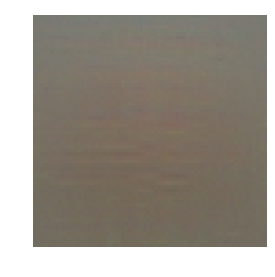

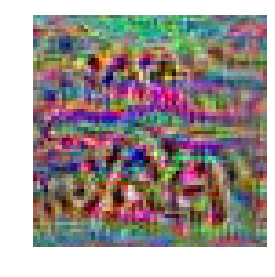

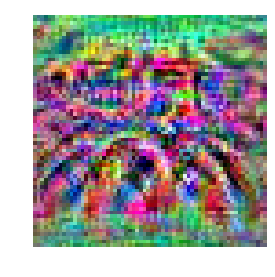

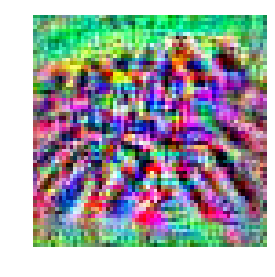

In [24]:
target_y = 43 # Tarantula
print data['class_names'][target_y]
X = create_class_visualization(target_y, model, show_every=25)

# Feature Inversion
In an attempt to understand the types of features that convolutional networks learn to recognize, a recent paper [1] attempts to reconstruct an image from its feature representation. We can easily implement this idea using image gradients from the pretrained network.

Concretely, given a image $I$, let $\phi_\ell(I)$ be the activations at layer $\ell$ of the convolutional network $\phi$. We wish to find an image $I^*$ with a similar feature representation as $I$ at layer $\ell$ of the network $\phi$ by solving the optimization problem

$$
I^* = \arg\min_{I'} \|\phi_\ell(I) - \phi_\ell(I')\|_2^2 + R(I')
$$

where $\|\cdot\|_2^2$ is the squared Euclidean norm. As above, $R$ is a (possibly implicit) regularizer. We can solve this optimization problem using gradient descent, computing gradients with respect to the generated image. We will use (explicit) L2 regularization of the form

$$
R(I') + \lambda \|I'\|_2^2
$$

together with implicit regularization by periodically blurring the image, as recommended by [2].

Implement this method in the function below.

[1] Aravindh Mahendran, Andrea Vedaldi, "Understanding Deep Image Representations by Inverting them", CVPR 2015

[2] Yosinski et al, "Understanding Neural Networks Through Deep Visualization", ICML 2015 Deep Learning Workshop

In [39]:
def invert_features(target_feats, layer, model, **kwargs):
  """
  Perform feature inversion in the style of Mahendran and Vedaldi 2015, using
  L2 regularization and periodic blurring.
  
  Inputs:
  - target_feats: Image features of the target image, of shape (1, C, H, W);
    we will try to generate an image that matches these features
  - layer: The index of the layer from which the features were extracted
  - model: A PretrainedCNN that was used to extract features
  
  Keyword arguments:
  - learning_rate: The learning rate to use for gradient descent
  - num_iterations: The number of iterations to use for gradient descent
  - l2_reg: The strength of L2 regularization to use; this is lambda in the
    equation above.
  - blur_every: How often to blur the image as implicit regularization; set
    to 0 to disable blurring.
  - show_every: How often to show the generated image; set to 0 to disable
    showing intermediate reuslts.
    
  Returns:
  - X: Generated image of shape (1, 3, 64, 64) that matches the target features.
  """
  learning_rate = kwargs.pop('learning_rate', 10000)
  num_iterations = kwargs.pop('num_iterations', 500)
  l2_reg = kwargs.pop('l2_reg', 1e-7)
  blur_every = kwargs.pop('blur_every', 1)
  show_every = kwargs.pop('show_every', 50)
  
  X = np.random.randn(1, 3, 64, 64)
  for t in xrange(num_iterations):
    ############################################################################
    # TODO: Compute the image gradient dX of the reconstruction loss with      #
    # respect to the image. You should include L2 regularization penalizing    #
    # large pixel values in the generated image using the l2_reg parameter;    #
    # then update the generated image using the learning_rate from above.      #
    ############################################################################
    out, cache = model.forward(X, end=layer)
    #loss = 0.5*np.linalg.norm(target_feats.reshape(-1)-out.reshape(-1))**2 + 0.5*l2_reg*np.linalg.norm(out.reshape(-1))**2
    dout = out - target_feats
    dX, grads = model.backward(dout, cache)
    X -= learning_rate*(dX+l2_reg*X)
    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################
    
    # As a regularizer, clip the image
    X = np.clip(X, -data['mean_image'], 255.0 - data['mean_image'])
    
    # As a regularizer, periodically blur the image
    if (blur_every > 0) and t % blur_every == 0:
      X = blur_image(X)

    if (show_every > 0) and (t % show_every == 0 or t + 1 == num_iterations):
      plt.imshow(deprocess_image(X, data['mean_image']))
      plt.gcf().set_size_inches(3, 3)
      plt.axis('off')
      plt.title('t = %d' % t)
      plt.show()

### Shallow feature reconstruction
After implementing the feature inversion above, run the following cell to try and reconstruct features from the fourth convolutional layer of the pretrained model. You should be able to reconstruct the features using the provided optimization parameters.

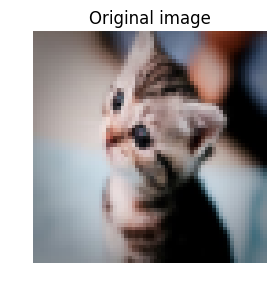

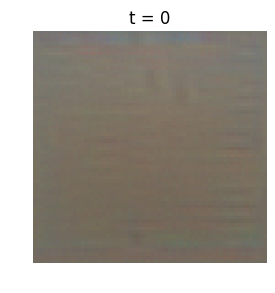

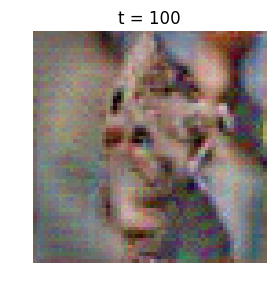

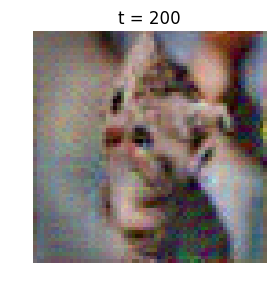

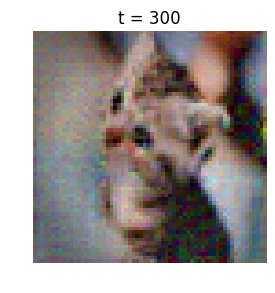

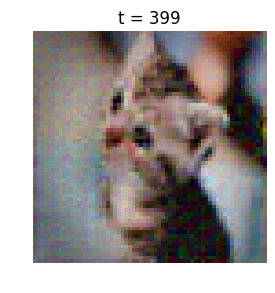

In [40]:
filename = 'kitten.jpg'
layer = 3 # layers start from 0 so these are features after 4 convolutions
img = imresize(imread(filename), (64, 64))

plt.imshow(img)
plt.gcf().set_size_inches(3, 3)
plt.title('Original image')
plt.axis('off')
plt.show()

# Preprocess the image before passing it to the network:
# subtract the mean, add a dimension, etc
img_pre = preprocess_image(img, data['mean_image'])

# Extract features from the image
feats, _ = model.forward(img_pre, end=layer)

# Invert the features
kwargs = {
  'num_iterations': 400,
  'learning_rate': 5000,
  'l2_reg': 1e-8,
  'show_every': 100,
  'blur_every': 10,
}
X = invert_features(feats, layer, model, **kwargs)

### Deep feature reconstruction
Reconstructing images using features from deeper layers of the network tends to give interesting results. In the cell below, try to reconstruct the best image you can by inverting the features after 7 layers of convolutions. You will need to play with the hyperparameters to try and get a good result.

HINT: If you read the paper by Mahendran and Vedaldi, you'll see that reconstructions from deep features tend not to look much like the original image, so you shouldn't expect the results to look like the reconstruction above. You should be able to get an image that shows some discernable structure within 1000 iterations.

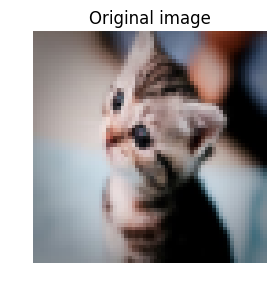

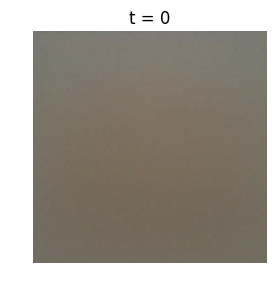

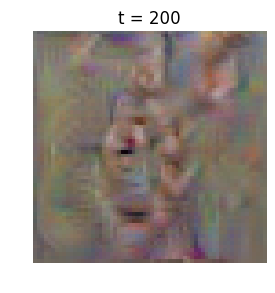

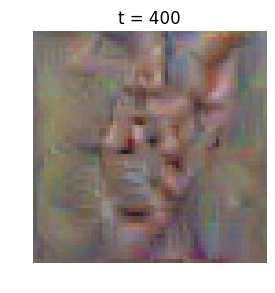

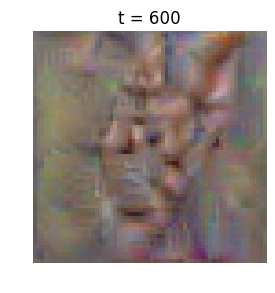

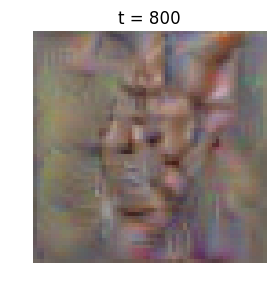

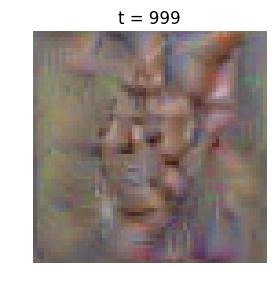

In [47]:
filename = 'kitten.jpg'
layer = 6 # layers start from 0 so these are features after 7 convolutions
img = imresize(imread(filename), (64, 64))

plt.imshow(img)
plt.gcf().set_size_inches(3, 3)
plt.title('Original image')
plt.axis('off')
plt.show()

# Preprocess the image before passing it to the network:
# subtract the mean, add a dimension, etc
img_pre = preprocess_image(img, data['mean_image'])

# Extract features from the image
feats, _ = model.forward(img_pre, end=layer)

# Invert the features
# You will need to play with these parameters.
kwargs = {
  'num_iterations': 1000,
  'learning_rate': 20000,
  'l2_reg': 1e-7,
  'show_every': 200,
  'blur_every': 10,
}
X = invert_features(feats, layer, model, **kwargs)

# DeepDream
In the summer of 2015, Google released a [blog post](http://googleresearch.blogspot.com/2015/06/inceptionism-going-deeper-into-neural.html) describing a new method of generating images from neural networks, and they later [released code](https://github.com/google/deepdream) to generate these images.

The idea is very simple. We pick some layer from the network, pass the starting image through the network to extract features at the chosen layer, set the gradient at that layer equal to the activations themselves, and then backpropagate to the image. This has the effect of modifying the image to amplify the activations at the chosen layer of the network.

For DeepDream we usually extract features from one of the convolutional layers, allowing us to generate images of any resolution.

We can implement this idea using our pretrained network. The results probably won't look as good as Google's since their network is much bigger, but we should still be able to generate some interesting images.

In [60]:
def deepdream(X, layer, model, **kwargs):
  """
  Generate a DeepDream image.
  
  Inputs:
  - X: Starting image, of shape (1, 3, H, W)
  - layer: Index of layer at which to dream
  - model: A PretrainedCNN object
  
  Keyword arguments:
  - learning_rate: How much to update the image at each iteration
  - max_jitter: Maximum number of pixels for jitter regularization
  - num_iterations: How many iterations to run for
  - show_every: How often to show the generated image
  """
  
  X = X.copy()
  
  learning_rate = kwargs.pop('learning_rate', 5.0)
  max_jitter = kwargs.pop('max_jitter', 16)
  num_iterations = kwargs.pop('num_iterations', 100)
  show_every = kwargs.pop('show_every', 25)
  
  for t in xrange(num_iterations):
    # As a regularizer, add random jitter to the image
    ox, oy = np.random.randint(-max_jitter, max_jitter+1, 2)
    X = np.roll(np.roll(X, ox, -1), oy, -2)

    dX = None
    ############################################################################
    # TODO: Compute the image gradient dX using the DeepDream method. You'll   #
    # need to use the forward and backward methods of the model object to      #
    # extract activations and set gradients for the chosen layer. After        #
    # computing the image gradient dX, you should use the learning rate to     #
    # update the image X.                                                      #
    ############################################################################
    out, cache = model.forward(X, end=layer)
    dX, _ = model.backward(out, cache)
    X += learning_rate*dX
    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################
    
    # Undo the jitter
    X = np.roll(np.roll(X, -ox, -1), -oy, -2)
    
    # As a regularizer, clip the image
    mean_pixel = data['mean_image'].mean(axis=(1, 2), keepdims=True)
    X = np.clip(X, -mean_pixel, 255.0 - mean_pixel)
    
    # Periodically show the image
    if t == 0 or (t + 1) % show_every == 0:
      img = deprocess_image(X, data['mean_image'], mean='pixel')
      plt.imshow(img)
      plt.title('t = %d' % (t + 1))
      plt.gcf().set_size_inches(8, 8)
      plt.axis('off')
      plt.show()
  return X

# Generate some images!
Try and generate a cool-looking DeepDeam image using the pretrained network. You can try using different layers, or starting from different images. You can reduce the image size if it runs too slowly on your machine, or increase the image size if you are feeling ambitious.

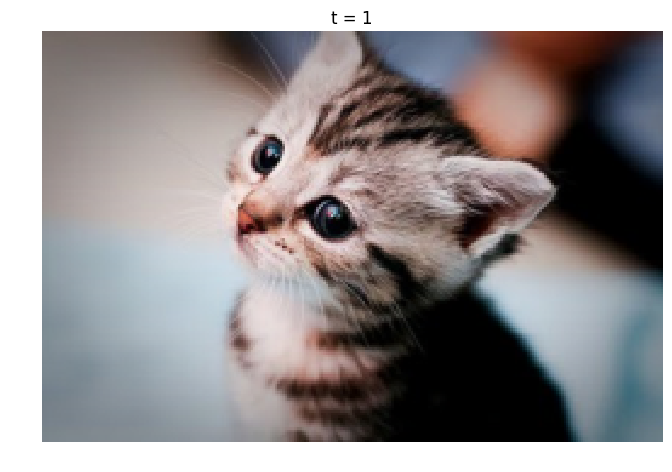

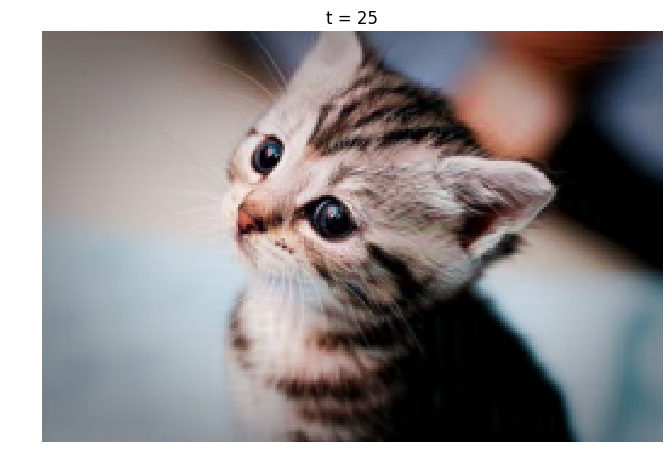

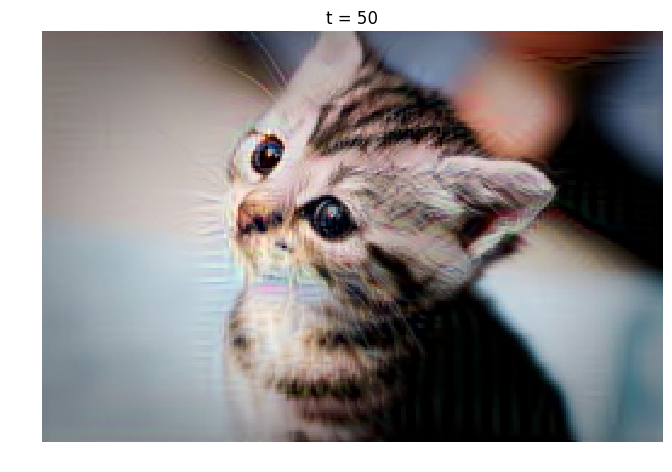

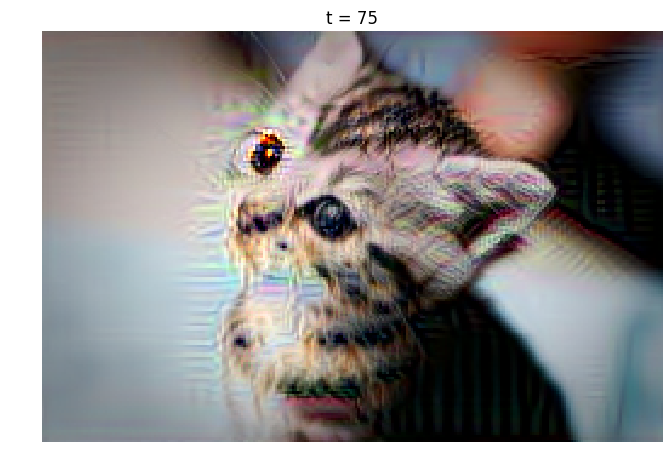

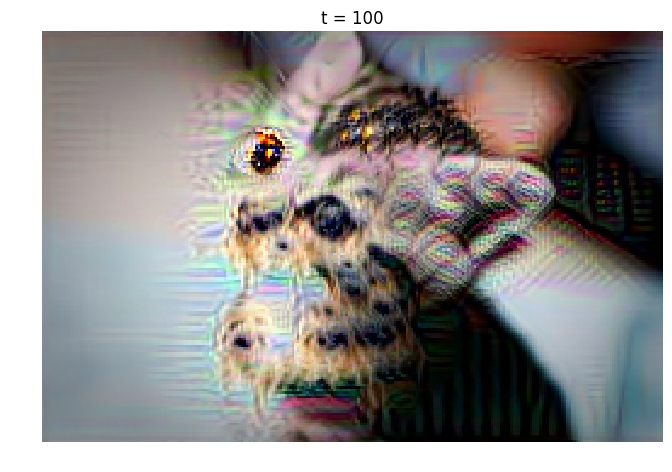

In [63]:
def read_image(filename, max_size):
  """
  Read an image from disk and resize it so its larger side is max_size
  """
  img = imread(filename)
  H, W, _ = img.shape
  if H >= W:
    img = imresize(img, (max_size, int(W * float(max_size) / H)))
  elif H < W:
    img = imresize(img, (int(H * float(max_size) / W), max_size))
  return img

filename = 'kitten.jpg'
max_size = 256
img = read_image(filename, max_size)
plt.imshow(img)
plt.axis('off')

# Preprocess the image by converting to float, transposing,
# and performing mean subtraction.
img_pre = preprocess_image(img, data['mean_image'], mean='pixel')

out = deepdream(img_pre, 7, model, learning_rate=2000)

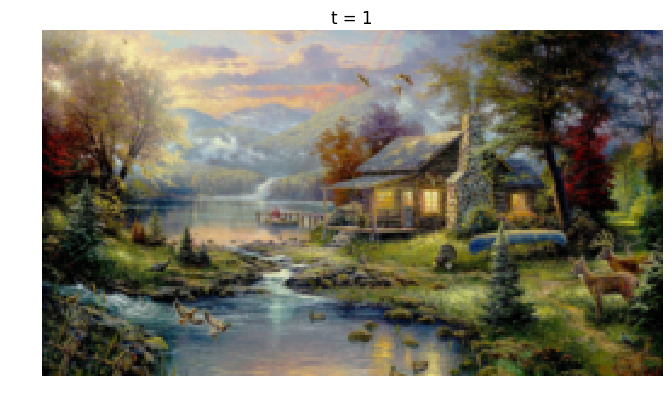

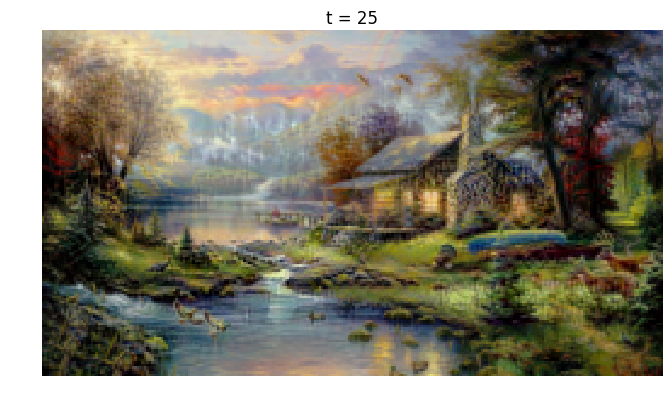

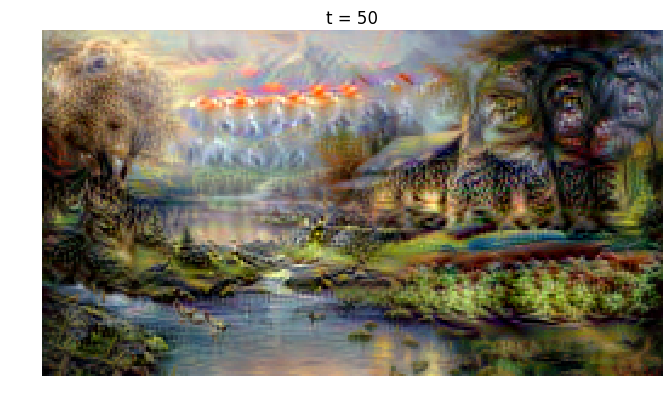

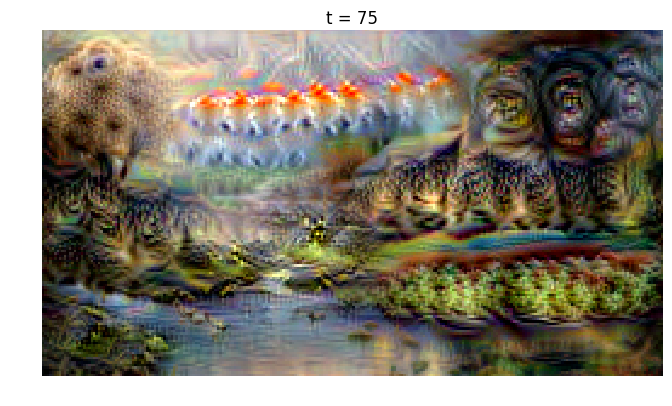

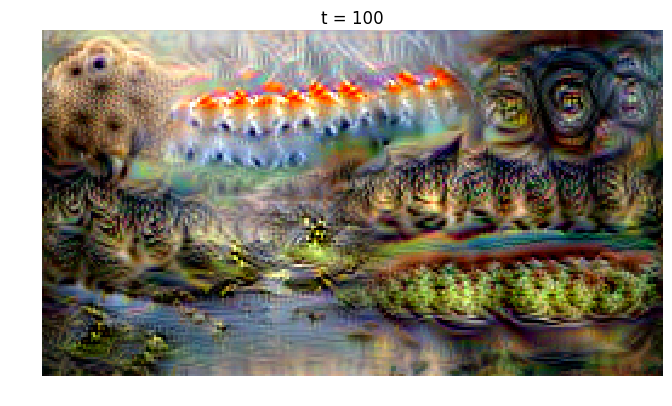

In [62]:
filename = 'painting.jpg'
max_size = 256
img = read_image(filename, max_size)
plt.imshow(img)
plt.axis('off')

# Preprocess the image by converting to float, transposing,
# and performing mean subtraction.
img_pre = preprocess_image(img, data['mean_image'], mean='pixel')

out = deepdream(img_pre, 7, model, learning_rate=2000)